### Tarea 02 - Aprendizaje maquina

### Giovanni Gamaliel López Padilla


#### Organización de la carpeta 

```bash
├── data
│  ├── test
│  │  ├── NORMAL
│  │  └── PNEUMONIA
│  ├── train
│  │  ├── NORMAL
│  │  └── PNEUMONIA
│  └── val
│     ├── NORMAL
│     └── PNEUMONIA
├── results
│  ├── all.csv
│  ├── best_model.hdf5
│  ├── last_conv.csv
│  └── none.csv
└── Tarea02.ipynb

```

datasets

In [9]:
from os import stat as check_path
from os.path import join


def set_paths(params: dict) -> dict:
    """
    Creacion y verificación de las rutas de los datos de entrenamiento, validacion y test. 

    Inputs:
    -------------------------
    params -> directorio con las rutas y nombres de cada tipo de dato y clases
        params["path data"] -> path base de los datos
        params["path results"] -> path base de los resultados
        params["folders"] -> nombre de las carpetas para los tipo de datos
        params["data classes"] -> nombre de las clases a clasificar
    """
    try:
        # Directorio con la DB pequeña
        paths = {}
        path = params["path data"]
        check_path(path)
        path = params["path results"]
        check_path(path)
        # Directorios de entrenamiento validacion y evaluacion
        for folder in params["folders"]:
            path = join(params["path data"],
                        folder)
            check_path(path)
            paths[folder] = {}
            paths[folder]["base"] = path
            # Directiorios de cada clase de dato
            for classes in params["data classes"]:
                path = join(params["path data"],
                            folder,
                            classes)
                check_path(path)
                paths[folder][classes] = path
        print('Estructura de directorios completa')
        return paths
    except:
        print('Estructura de directorios incompleta')
        return {}


def get_params() -> dict:
    """
    parametros de los datos a tratar
    """
    params = {
        "path data": "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_02/data",
        "path results": "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_02/results",
        "folders": ["train",
                    "val",
                    "test"],
        "data classes": ["NORMAL",
                         "PNEUMONIA"],
        "train types": ["all",
                        "last conv",
                        "none"],
        "last conv": [165, 168, 171],
        "epoch": 20,
        "batch size": 32,
    }
    params["paths"] = set_paths(params)
    return params

models

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from pandas import DataFrame
from keras import optimizers
from os.path import join
from keras import models
from keras import layers
import time


class generator_model_class:
    def __init__(self, params):
        """
        Contiene los metodos para generar imagenes a partir de las encontradas en las rutas de entrenamiento y test

        Inputs:
        -----------------------
        params -> directorio con los diferentes parámetros a usar
            params["paths"] -> diccionario con las diferentes rutas de los archivos
                params["paths"]["train"] -> directorio con las diferentes rutas de datos de entrenamiento
                    params["paths"]["train"]["base"] -> ruta de los documentos de entrenamiento
                params["paths"]["test"] -> directorio con las diferentes rutas de los datos de test
                    params["paths"]["test"]["base"] -> ruta con los documentos de test
        """

        self.params = params
        self.batch_size = params["batch size"]
        self.set_train()
        self.set_test()

    def set_train(self) -> None:
        """
        Creacion de los generadores de datos para los datos de entrenamiento
        """
        train_datagen = ImageDataGenerator(rescale=1./255,
                                           rotation_range=40,
                                           width_shift_range=0.2,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode='nearest')
        self.train = train_datagen.flow_from_directory(
            self.params["paths"]["train"]["base"],
            target_size=(150, 150),
            batch_size=self.batch_size,
            class_mode='binary')

    def set_test(self) -> None:
        """
        Creacion de los generadores de datos para los datos de test
        """
        test_datagen = ImageDataGenerator(rescale=1./255)
        self.test = test_datagen.flow_from_directory(
            self.params["paths"]["test"]["base"],
            target_size=(150, 150),
            batch_size=self.batch_size,
            class_mode='binary')


class neural_model_class:
    def __init__(self, params: dict) -> None:
        """
        Modelo neuronal utilizado para clasificar imagenes de rayos x

        Inputs
        ----------------------
        params -> directorio con los diferentes parámetros a usar
        """
        self.params = params
        self.conv_base = ResNet50(weights='imagenet',
                                  include_top=False,
                                  input_shape=(150, 150, 3))
        # Inicializacion de la clase
        self.model = models.Sequential()
        # Modelo base agregado
        self.model.add(self.conv_base)
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(256,
                                    activation='relu'))
        self.model.add(layers.Dense(64,
                                    activation='relu'))
        self.model.add(layers.Dense(1,
                                    activation='sigmoid'))
        self.layer_num = len(self.conv_base.layers)
        self.best_version()

    def freeze_conv_base(self, which: str) -> None:
        """
        Seleccion de las capas a congelar

        Inputs:
        ---------------------------
        which -> string que selecciona que capas congelar
        """
        if which == "all":
            idx = list(range(self.layer_num))
        if which == "last conv":
            idx = list(range(self.layer_num))
            for id in self.params["last conv"]:
                idx.remove(id)
        if which == "none":
            idx = []
        for id, layer in enumerate(self.conv_base.layers):
            if id in idx:
                self.conv_base.layers[id].trainable = False
            else:
                self.conv_base.layers[id].trainable = True
        self.compile()

    def compile(self):
        """
        Compilacion del modelo creado
        """
        self.model.compile(loss='binary_crossentropy',
                           optimizer="nadam",
                           metrics=['acc'])

    def best_version(self):
        """
        Método para guardar de forma automatica la mejor version obtenida en el entrenamiento
        """
        filename = join(self.params["path results"],
                        "best_model.hdf5")
        self.checkpoint = ModelCheckpoint(
            filename,
            monitor='val_acc',
            verbose=2,
            save_best_only=True)

    def run(self, generator: generator_model_class) -> None:
        """
        Ejeccccion del entrenamiento del modelo para los diferentes tipos de congelamiento

        Inputs:
        -----------------------
        generator -> clase que contiene el generador de los datos de entrenamiento y test
        """
        self.history = {}
        for train_type in self.params["train types"]:
            self.history[train_type] = DataFrame()
        for select_layers in self.history:
            self.freeze_conv_base(select_layers)
            self.history[select_layers] = self.fit(generator)
        self.save_history()

    def fit(self, generator: generator_model_class) -> DataFrame:
        """
        Ejeccuccion del entrenamiento el modelo para una estructura especifica

        Inputs:
        -----------------------
        generator -> clase que contiene el generador de los datos de entrenamiento y test
        """
        time_start = time.time()
        train_steps = generator.train.samples // generator.batch_size
        validation_steps = generator.test.samples // generator.batch_size
        history = self.model.fit(
            generator.train,
            steps_per_epoch=train_steps,
            epochs=self.params["epoch"],
            validation_data=generator.test,
            validation_steps=validation_steps,
            callbacks=[self.checkpoint],
            verbose=1)
        print('seconds = {}'.format(time.time()-time_start))
        results = history.history
        return DataFrame(results)

    def save_history(self) -> None:
        """
        Guardado de los parametros en cada epoca de entrenamiento para los diferentes tipos de congelamiento
        """
        for train_type in self.history:
            data = self.history[train_type]
            data.index.name = "Epochs"
            filename = train_type.replace(" ", "_")
            filename = "{}.csv".format(filename)
            filename = join(self.params["path results"],
                            filename)
            data.to_csv(filename)

run

In [ ]:
params = get_params()
generator_model = generator_model_class(params)
neural_model = neural_model_class(params)

Estructura de directorios completa
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
neural_model.run(generator_model)

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.6177 - acc: 0.7303
Epoch 1: val_acc improved from -inf to 0.62336, saving model to /content/drive/MyDrive/results/best_model.hdf5
163/163 [==============================] - 121s 697ms/step - loss: 0.6177 - acc: 0.7303 - val_loss: 0.6426 - val_acc: 0.6234
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.4701 - acc: 0.7636
Epoch 2: val_acc improved from 0.62336 to 0.70724, saving model to /content/drive/MyDrive/results/best_model.hdf5
163/163 [==============================] - 114s 697ms/step - loss: 0.4701 - acc: 0.7636 - val_loss: 0.5049 - val_acc: 0.7072
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.4090 - acc: 0.7922
Epoch 3: val_acc did not improve from 0.70724
163/163 [==============================] - 114s 696ms/step - loss: 0.4090 - acc: 0.7922 - val_loss: 0.5544 - val_acc: 0.6974
Epoch 4/20
163/163 [==============================] - ETA: 0s - loss: 0.4060 - ac

graphic

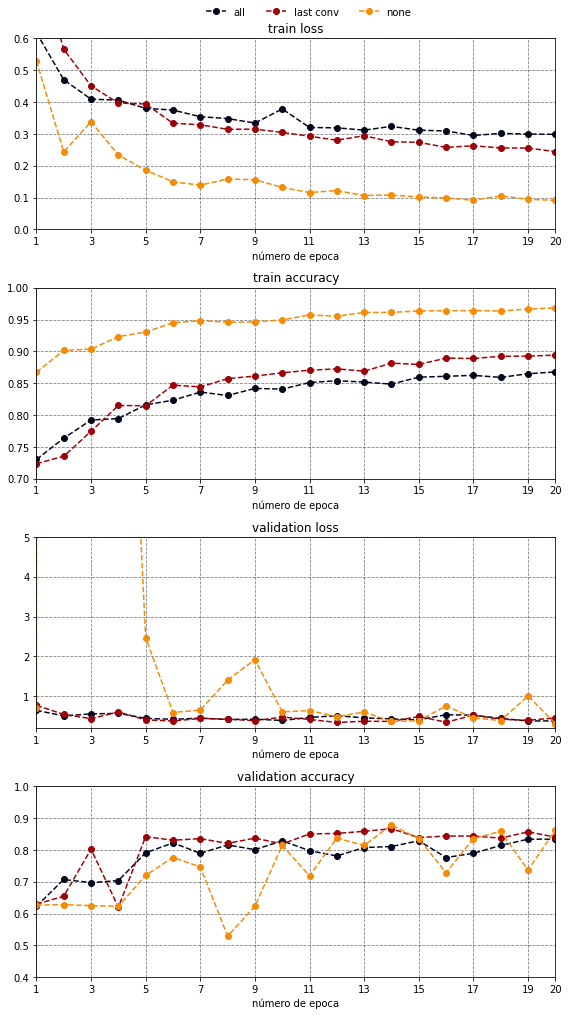

In [13]:
from numpy import linspace, array
import matplotlib.pyplot as plt
from pandas import read_csv
from os.path import join

datasets_parameters = {
    "loss": {
        "y lim": [0, 0.6],
        "title": "train loss"
    },
    "acc": {
        "y lim": [0.7, 1],
        "title": "train accuracy"},
    "val_loss": {
        "y lim": [0.2, 5],
        "title": "validation loss"
    },
    "val_acc": {
        "y lim": [0.4, 1],
        "title": "validation accuracy"
    },
}
colors = {"all": "#03071e",
          "last conv": "#9d0208",
          "none": "#f48c06"}

history = {}
for train_type in params["train types"]:
    filename = train_type.replace(" ", "_")
    filename = "{}.csv".format(filename)
    filename = join(params["path results"],
                    filename)
    data = read_csv(filename,
                    index_col=0)
    history[train_type] = data.copy()

xticks = list(range(0, 20, 2))
xticks += [19]
xticks = array(xticks)
fig, axs = plt.subplots(4, 1, figsize=(8, 14))
for i, train_type in enumerate(history):
    data = history[train_type]
    color = colors[train_type]
    for ax, parameter in zip(axs, data.columns):
        dataset = datasets_parameters[parameter]
        parameter_data = data[parameter]
        epochs = list(data.index)
        ax.set_title(dataset["title"])
        ax.plot(epochs,
                parameter_data,
                label=train_type,
                color=color,
                ls="--",
                marker="o")
        ax.set_xlabel("número de epoca")
        ax.set_xlim(epochs[0], epochs[-1])
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks+1)
        ax.set_ylim(dataset["y lim"][0],
                    dataset["y lim"][1])
        ax.grid(ls="--",
                color="#000000",
                alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,
           labels,
           bbox_to_anchor=(0.73, 1.01),
           ncol=3,
           frameon=False
           )
plt.tight_layout()
plt.show()

Con los resultados anteriores se muestra que el tiempo en cada epoca es  más tardado cuando se contemplan todos los parámetros de cada capa, en cambio los tiempo entre un congelamiento parcial y total de las capas de la red preentrenada son muy semejantes. 

En este caso se muestra que la red con un congelamiento parcial obtiene una mayor cantidad de resultados comparables al mejor, por lo que se preferiria aumentar el número de epocas de este tipo de entrenamiento en vez de cambiar a un entrenamiento descongelando la red preentrenada.